In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")
_set_env("HF_TOKEN")

In [2]:
from langchain.chat_models import init_chat_model

chat_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [3]:
def add(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def subtract(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def multiply(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

tools = [add, subtract, multiply, divide]
llm_with_tools = chat_model.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistance tasked with performing arthemation on give set of inputs. Verify your output at each step.")

def assistance(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

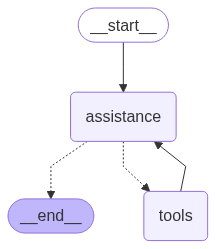

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)
builder.add_node("assistance", assistance)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistance")
builder.add_conditional_edges(
    "assistance",
    # If the latest message (result) from assisatnce is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistance")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
initial_input = {"messages":"Multiply 2 and 3"}

thread = {"configurable": {"thread_id":"1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b3dab58a-f660-4953-897d-64b006257492)
 Call ID: b3dab58a-f660-4953-897d-64b006257492
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The answer is 6.


In [7]:
graph.get_state({'configurable':{'thread_id':'1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a6e1fa84-0992-44ee-96d4-963da251a607'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--44a07068-929d-4928-87df-4b7c6d8a1901-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': 'b3dab58a-f660-4953-897d-64b006257492', 'type': 'tool_call'}], usage_metadata={'input_tokens': 98, 'output_tokens': 5, 'total_tokens': 103, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='6', name='multiply', id='8dd1777b-dcb1-41af-a107-3a021da55ad5', tool_call_id='b3dab58a-f660-4953-897d-64b006257492'), AIMessage(content='The answer is 6.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason'

In [8]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

In [12]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a6e1fa84-0992-44ee-96d4-963da251a607')]}, next=('assistance',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05b003-a822-6ca9-8000-158d5f7afc45'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-07T07:01:38.822263+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05b003-a819-60cf-bfff-f2eff4512be9'}}, tasks=(PregelTask(id='4392c587-9464-ce1b-fa9d-03cc51c7927e', name='assistance', path=('__pregel_pull', 'assistance'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'sa